In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec 10 16:18:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp -r '/content/src' '/content/drive/My Drive/Colab Notebooks/project_facenet/'

In [ ]:
!cp -r  '/content/drive/My Drive/Colab Notebooks/project_facenet/src' '/content/src'

##**Загрузим датасеты**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mila601","key":"d7296722c70eeeb1367e467aad3d6cc7"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Dec 10 06:47 kaggle.json


In [ ]:
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list --mine

ref                              title                     size  lastUpdated          downloadCount  
-------------------------------  -----------------------  -----  -------------------  -------------  
mila601/rfw-image                RFW_image                  1GB  2020-10-24 15:41:08             49  
mila601/train-caucasian          train_caucasian           15GB  2020-11-27 23:33:49             16  
mila601/target-african           target_african             2GB  2020-11-28 08:06:26             15  
mila601/transferface-lmk         transferface_lmk          13MB  2020-12-02 19:33:08              7  
mila601/nlp-made-hw5             nlp_made_hw5             844MB  2020-07-03 19:59:45              9  
mila601/made-cv-hw1-test-points  made_cv_hw1_test_points    8MB  2020-05-05 21:02:40             15  
mila601/target-indian            target_indian              2GB  2020-12-09 21:13:23              1  


In [ ]:
!kaggle datasets download -d mila601/rfw-image

 98% 1.25G/1.28G [00:16<00:00, 61.0MB/s]
100% 1.28G/1.28G [00:16<00:00, 82.5MB/s]


In [ ]:
# Скачаем train-caucasian
!kaggle datasets download -d mila601/train-caucasian

100% 15.0G/15.0G [03:11<00:00, 97.2MB/s]
100% 15.0G/15.0G [03:11<00:00, 84.0MB/s]


In [ ]:
# Скачаем target_african
!kaggle datasets download -d mila601/target-african

 99% 1.52G/1.53G [00:20<00:00, 62.3MB/s]
100% 1.53G/1.53G [00:20<00:00, 79.3MB/s]


In [ ]:
# Скачаем target_indian
!kaggle datasets download -d mila601/target-indian

 99% 1.68G/1.70G [00:20<00:00, 79.2MB/s]
100% 1.70G/1.70G [00:20<00:00, 86.9MB/s]


In [ ]:
# Скачаем 
!kaggle datasets download -d mila601/transferface-lmk

 38% 5.00M/13.3M [00:00<00:00, 28.8MB/s]
100% 13.3M/13.3M [00:00<00:00, 52.7MB/s]


In [ ]:
!unzip \*.zip

In [ ]:
!rm rfw-image.zip
!rm target-african.zip
!rm train-caucasian.zip
!rm target-indian.zip

In [ ]:
!cp -r /content/Indian /content/Indian_/Indian

In [ ]:
# !pip install -e git+https://github.com/timesler/facenet-pytorch.git#egg=facenet

Obtaining facenet from git+https://github.com/timesler/facenet-pytorch.git#egg=facenet
  Cloning https://github.com/timesler/facenet-pytorch.git to ./src/facenet
  Running command git clone -q https://github.com/timesler/facenet-pytorch.git /content/src/facenet
  Running command git submodule update --init --recursive -q
  Running setup.py develop for facenet-pytorch


In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
import glob
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.nn import functional as F
from torch.utils import data

import random
from torchvision import datasets, transforms
from src.facenet import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import torch

from PIL import Image, ImageFile
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

workers = 0 if os.name == 'nt' else 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
my_transforms= transforms.Compose([ np.float32,
                                    transforms.ToTensor(),
                                    fixed_image_standardization,
                                    transforms.Resize((220,220)),
                                    transforms.CenterCrop((160,160))])


source_domain_dataset = datasets.ImageFolder('Caucasian',
                                                 transform=my_transforms)

target_domain_dataset = datasets.ImageFolder('Indian_',
                                                 transform=my_transforms)


In [ ]:
len(target_domain_dataset.samples), len(source_domain_dataset.samples)

(52285, 468139)

In [ ]:
model = InceptionResnetV1(pretrained='vggface2')
model.logits = torch.nn.Linear(512, len(source_domain_dataset.classes))
model = model.to(device)

Обучим отдельно последний слой

In [ ]:
img_inds = np.arange(len(source_domain_dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.9 * len(img_inds))]
val_inds = img_inds[int(0.9 * len(img_inds)):]

batch_size = 128
train_loader = DataLoader(
    source_domain_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    source_domain_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
# Заморозили всё, кроме последнего слоя, чтобы обучить последний слой
for name, param in model.named_parameters():
    if not 'logits' in name:
        param.requires_grad = False

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [3], gamma = 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}
epochs = 2

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
training.pass_epoch(
    model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    training.pass_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    training.pass_epoch(
        model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |   366/366  | loss:    9.3606 | fps:  547.4875 | acc:    0.0001   

Epoch 1/2
----------
Train |  3292/3292 | loss:    1.4219 | fps:  425.3130 | acc:    0.8052   
Valid |   366/366  | loss:    0.3513 | fps:  533.2799 | acc:    0.9264   

Epoch 2/2
----------
Train |  3292/3292 | loss:    0.3055 | fps:  427.0642 | acc:    0.9295   
Valid |   366/366  | loss:    0.3183 | fps:  533.1542 | acc:    0.9259   


In [ ]:
# Specify a path
PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_freeze_1pretraining_2911.pth'

# Save
torch.save(model, PATH)

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_freeze_1pretraining_2911.pth'
model = torch.load(PATH)

In [ ]:
# Разморозили
for name, param in model.named_parameters():
#    if not 'logits' in name:
  param.requires_grad = True

In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image )
metric_RFW('Caucasian', model, transform_image )

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [11:29<00:00, 14.95it/s]


roc_auc_score = 0.9030569999999999
(trashold, accuracy) =  (0.5804020100502513, 0.8286666666666667) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [11:17<00:00, 15.05it/s]


roc_auc_score = 0.9598948888888887
(trashold, accuracy) =  (0.4115577889447236, 0.8973333333333333) 



##**Stage 1: Pre-training**

In [ ]:
source_domain_loader = torch.utils.data.DataLoader(
    source_domain_dataset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

target_domain_loader = torch.utils.data.DataLoader(
    target_domain_dataset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

# Сделаем train  и validate
img_inds = np.arange(len(target_domain_dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

target_domain_pretraining_train_loader = torch.utils.data.DataLoader(
    target_domain_dataset, batch_size=128,
    num_workers=4, pin_memory=True, drop_last=True, sampler=SubsetRandomSampler(train_inds))
target_domain_pretraining_val_loader = torch.utils.data.DataLoader(
    target_domain_dataset, batch_size=128, 
    num_workers=4, pin_memory=True, drop_last=True, sampler=SubsetRandomSampler(val_inds))

img_inds = np.arange(len(source_domain_dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.9 * len(img_inds))]
val_inds = img_inds[int(0.9 * len(img_inds)):]
source_domain_train_loader = torch.utils.data.DataLoader(
    source_domain_dataset, batch_size=128,
    num_workers=4, pin_memory=True, drop_last=True, sampler=SubsetRandomSampler(train_inds))

source_domain_val_loader = torch.utils.data.DataLoader(
    source_domain_dataset, batch_size=128,
    num_workers=4, pin_memory=True, drop_last=True, sampler=SubsetRandomSampler(val_inds))



In [ ]:
%autoreload 2
from iman_steps import pretraining_epoch, accuracy


# до BN
metrics = {
    'acc': accuracy
}
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10


n_epochs = 1


s_clf_loss, mmd_loss, s_clf_loss_val, mmd_loss_val = [], [], [], []
for epoch in range(1, n_epochs + 1):

  model.train()
  s_clf_loss_epoch, mmd_loss_epoch = pretraining_epoch(model, source_domain_train_loader, 
                                           target_domain_pretraining_train_loader, 
                                           optimizer, device, lambda_=10, writer = writer, batch_metrics=metrics)
  s_clf_loss += s_clf_loss_epoch
  mmd_loss += mmd_loss_epoch
  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: source clf loss: {:.6}, mmd loss: {:.7}, lr: {} \n".\
      format(epoch, np.mean(s_clf_loss_epoch), np.mean(mmd_loss_epoch), lr)) 
  
  model.eval()
  s_clf_loss_val, mmd_loss_val = pretraining_epoch(model, source_domain_val_loader, 
                                           target_domain_pretraining_val_loader, 
                                           optimizer, device, lambda_=10, writer = writer, batch_metrics=metrics)
  print("Epoch #{} validate: source clf loss: {:.6}, mmd loss: {:.7}, lr: {} \n".\
      format(epoch, np.mean(s_clf_loss_val), np.mean(mmd_loss_val), lr))
  
  # Specify a path
  PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_1pretraining_0812_10.pth'

  # Save
  torch.save(model, PATH)

  model.eval()
  metric_RFW('Indian', model, transform_image)
  metric_RFW('Caucasian', model, transform_image)


  
writer.close()     

Train |   436/3291 | s_clf_loss:   0.22525 | mmd_loss: 0.039365470 | acc:    0.9441   

In [ ]:
1+1

2

In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [08:51<00:00, 19.39it/s]


roc_auc_score = 0.9310598888888889


evaluating on RFW (Caucasian):   0%|          | 0/10196 [00:00<?, ?it/s]

(trashold, accuracy) =  (0.49296482412060305, 0.8578333333333333) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [08:37<00:00, 19.70it/s]


roc_auc_score = 0.9673225555555557
(trashold, accuracy) =  (0.44170854271356785, 0.9053333333333333) 



In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_1pretraining_0812_10.pth'
model = torch.load(PATH)

##**Stage 2: Pre-adaptation**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Возвр косинуcную близость между парами изображений
def cluster_test(model, data_loader, device):

  assert isinstance(data_loader.sampler, torch.utils.data.SequentialSampler)
  assert data_loader.drop_last == False

  # calculating domain embeddings
  domain_dataset_embeddings_list = []
  model.eval()
  for batch in tqdm(data_loader, total=len(data_loader), desc="extracting embeddings..."):
    t_input = batch[0].to(device)
    with torch.no_grad():
      batch_embeddings, _, _ = model(t_input, calc_scores=False)
    domain_dataset_embeddings_list.append(batch_embeddings.cpu())
  
  domain_dataset_embeddings = torch.cat(domain_dataset_embeddings_list, dim=0)
  
  
  n_nodes = len(data_loader.dataset)

  cos_sims_list = []

  for node_i in tqdm(range(n_nodes), desc="calculating cosine similarities..."):
    node_i_cos_sims = F.cosine_similarity(domain_dataset_embeddings[node_i: node_i+1], 
                                          domain_dataset_embeddings)
    cos_sims_list.append(node_i_cos_sims.view(1, -1))

  cos_sims = torch.cat(cos_sims_list, dim=0)
  
  return cos_sims


# возвр косинуснуую близость отдельно для с изобр того же класса и с изобр других классов
def get_cos_sims(cos_sims, data_loader):
  nodes_cos_sims_with_nodes_of_same_class=[]
  nodes_cos_sims_with_nodes_of_other_class=[]
  samples = data_loader.dataset.samples
  labels = torch.LongTensor([s[1] for s in samples])
  for node in range(cos_sims.size(0)):
    nodes_of_same_class_indexes = (labels == labels[node]).nonzero().flatten().tolist()
    nodes_of_same_class_indexes.remove(node)
    nodes_of_same_class_indexes = torch.LongTensor(nodes_of_same_class_indexes)
    nodes_of_same_class_sims = cos_sims[node][nodes_of_same_class_indexes]

    nodes_of_other_class_indexes = (labels != labels[node]).nonzero().flatten()
    nodes_of_other_class_sims = cos_sims[node][nodes_of_other_class_indexes]
    
    nodes_cos_sims_with_nodes_of_same_class.append(nodes_of_same_class_sims.mean().item())
    nodes_cos_sims_with_nodes_of_other_class.append(nodes_of_other_class_sims.mean().item())

  return nodes_cos_sims_with_nodes_of_same_class, nodes_cos_sims_with_nodes_of_other_class

In [ ]:
%autoreload 2
from iman_steps import get_data_for_preadaptation
from collections import Counter

def clusterisation_check(preadaptation_dataloader):
  samples = preadaptation_dataloader.dataset.samples
  c = Counter([c[1] for c in preadaptation_dataloader.dataset.samples])
  plt.figure(figsize=(16, 6))
  plt.bar(c.keys(), c.values())
  plt.xlabel('labels')
  plt.ylabel('N samples')
  plt.show()

In [ ]:

# Важно, что shuffle=False, drop_last=False
target_domain_preadaptation_loader = torch.utils.data.DataLoader(
    target_domain_dataset, batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True, drop_last=False)

In [ ]:
sim_thresh = 0.78
min_cluster_size = 2 
max_cluster_size = 100

In [ ]:
len(target_domain_preadaptation_loader)

409

In [ ]:
len(target_domain_dataset.samples)

52285

In [ ]:
preadaptation_dataloader  = get_data_for_preadaptation(model, target_domain_preadaptation_loader, 
                                           device, sim_thresh, min_cluster_size, max_cluster_size)



In [ ]:
len(preadaptation_dataloader.dataset.samples)

33145

In [ ]:
len(target_domain_preadaptation_loader.dataset.samples)

52285

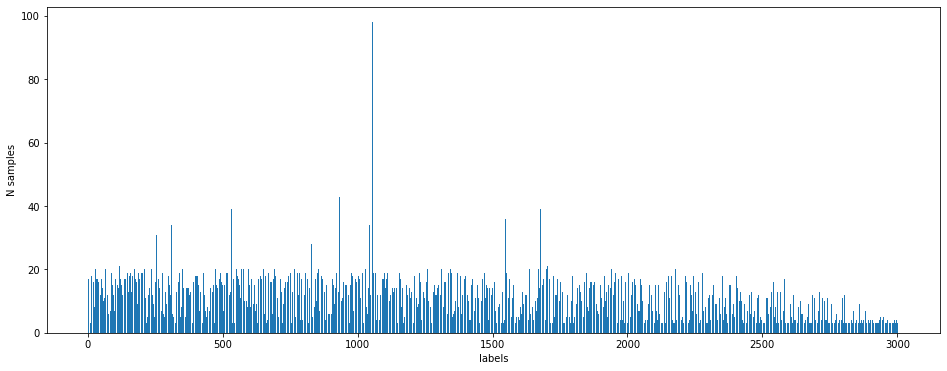

In [ ]:
clusterisation_check(preadaptation_dataloader )

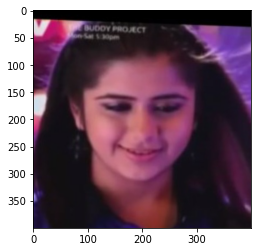

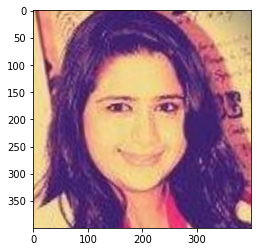

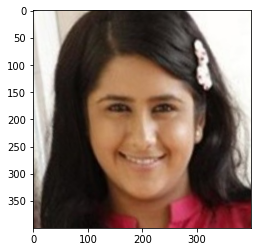

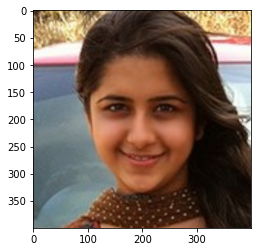

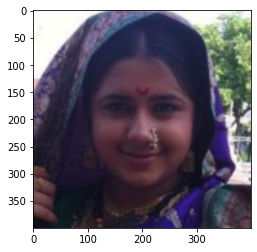

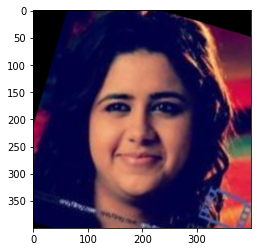

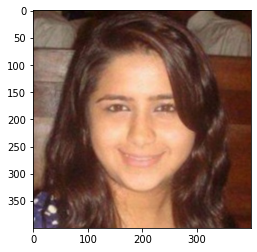

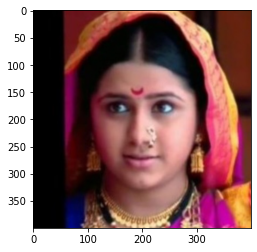

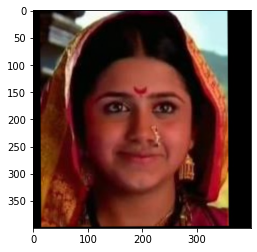

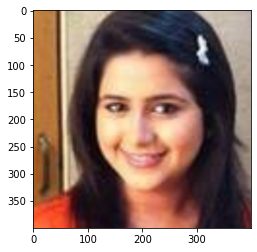

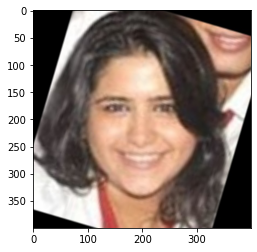

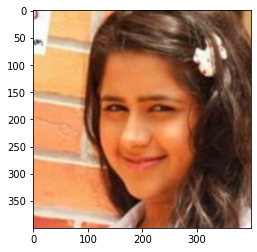

In [ ]:
def read_img(path):
    image = Image.open(path)
    return image

import time

for img_path, _ in [s for s in preadaptation_dataloader.dataset.samples if s[1] ==30]:
  plt.imshow(read_img(img_path))
  plt.show()

In [ ]:
%autoreload 2
from iman_steps import cluster, get_data_for_preadaptation, preadaptation_epoch

emb_size = 512
n_labels = len(set([x[1] for x in preadaptation_dataloader.dataset.samples]))

#target_domain_scoring = torch.nn.Linear(emb_size, n_labels)
class new_model(torch.nn.Module):
  def __init__(self, input_size, output_size):
      super().__init__()
      self.linear = torch.nn.Linear(input_size, output_size)

  def forward(self, x):
      x = self.linear(x).to(device)
      return x
target_domain_scoring = new_model(emb_size, n_labels).to(device)

In [ ]:
n_labels

3008

In [ ]:
class new_model(torch.nn.Module):
  def __init__(self, input_size, output_size):
      super().__init__()
      self.linear = torch.nn.Linear(input_size, output_size)

  def forward(self, x):
      x = self.linear(x).to(device)
      return x
target_domain_scoring = new_model(512, 3008).to(device)

**Обучим отдельно последний линейный слой**

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_1pretraining_0812_10.pth'
model = torch.load(PATH)

In [ ]:
model = model.to(device)

In [ ]:
# Заморозили всё в model
for name, param in model.named_parameters():
    param.requires_grad = False

In [ ]:
import tqdm
# accuracy классификации по кластерам
def target_domain_score_accuracy(model, loader, target_domain_scoring, device):
    model.eval()
    target_domain_scoring.eval()

    num_true = 0

    for batch in tqdm.tqdm_notebook(loader, total=len(loader), desc="extracting embeddings..."):
        x = batch[0].to(device)
        y = batch[1].to(device)
        with torch.no_grad():
          embeddings, _, _ = model(x, calc_scores=False)
          logits = target_domain_scoring(embeddings)
          _, preds = torch.max(logits, 1)
          num_true += int((preds == y).float().sum().item())

    return num_true / len(loader.dataset.samples)

In [ ]:
optimizer = torch.optim.SGD(target_domain_scoring.parameters(), lr=20)
n_epochs = 20

target_domain_scoring.train()
losses = []
for epoch in range(1, n_epochs + 1):
  model.eval()
  epoch_losses = preadaptation_epoch(model, preadaptation_dataloader,target_domain_scoring, 
                                     optimizer, device)
  losses += epoch_losses

  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, lr: {}".format(epoch, np.mean(epoch_losses), lr))


Epoch #1: loss: 7.24367, lr: 20



Epoch #2: loss: 5.79984, lr: 20



Epoch #3: loss: 4.61826, lr: 20



Epoch #4: loss: 3.64877, lr: 20



Epoch #5: loss: 2.89381, lr: 20



Epoch #6: loss: 2.32415, lr: 20



Epoch #7: loss: 1.89732, lr: 20



Epoch #8: loss: 1.58064, lr: 20



Epoch #9: loss: 1.33533, lr: 20



Epoch #10: loss: 1.14365, lr: 20



Epoch #11: loss: 0.991777, lr: 20



Epoch #12: loss: 0.86713, lr: 20



Epoch #13: loss: 0.763917, lr: 20



Epoch #14: loss: 0.677703, lr: 20



Epoch #15: loss: 0.60477, lr: 20



Epoch #16: loss: 0.542534, lr: 20



Epoch #17: loss: 0.48872, lr: 20



Epoch #18: loss: 0.441862, lr: 20



Epoch #19: loss: 0.401502, lr: 20



Epoch #20: loss: 0.365736, lr: 20


In [ ]:
optimizer = torch.optim.SGD(target_domain_scoring.parameters(), lr=2)
n_epochs = 5

target_domain_scoring.train()
losses = []
for epoch in range(1, n_epochs + 1):
  model.eval()
  epoch_losses = preadaptation_epoch(model, preadaptation_dataloader,target_domain_scoring, 
                                     optimizer, device)
  losses += epoch_losses

  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, lr: {}".format(epoch, np.mean(epoch_losses), lr))


Epoch #1: loss: 0.336044, lr: 2



Epoch #2: loss: 0.332806, lr: 2



Epoch #3: loss: 0.330125, lr: 2



Epoch #4: loss: 0.32719, lr: 2



Epoch #5: loss: 0.324467, lr: 2


In [ ]:
target_domain_score_accuracy(model, preadaptation_dataloader, target_domain_scoring, device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


0.9853069844622115

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_after_clusterization_target_domain_scoring_0812_032loss.pth'
# Save
torch.save(target_domain_scoring, PATH)

In [ ]:
# Разморозили
for name, param in model.named_parameters():
#    if not 'logits' in name:
  param.requires_grad = True

In [ ]:
from tqdm import tqdm

In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [08:48<00:00, 19.51it/s]


roc_auc_score = 0.9310598888888889


evaluating on RFW (Caucasian):   0%|          | 0/10196 [00:00<?, ?it/s]

(trashold, accuracy) =  (0.49296482412060305, 0.8578333333333333) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [08:35<00:00, 19.77it/s]


roc_auc_score = 0.9673225555555557
(trashold, accuracy) =  (0.44170854271356785, 0.9053333333333333) 



In [ ]:
optimizer = torch.optim.SGD([
                {'params': model.parameters(), 'lr': 0.001},
                {'params': target_domain_scoring.parameters(), 'lr': 0.01}
            ])

n_epochs = 7

losses = []
for epoch in range(1, n_epochs + 1):
  model.train()
  epoch_losses = preadaptation_epoch(model, preadaptation_dataloader,target_domain_scoring, 
                                     optimizer, device)
  losses += epoch_losses


  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, lr: {}".format(epoch, np.mean(epoch_losses), lr))


Epoch #1: loss: 0.363584, lr: 0.001



Epoch #2: loss: 0.343015, lr: 0.001



Epoch #3: loss: 0.334035, lr: 0.001



Epoch #4: loss: 0.328228, lr: 0.001



Epoch #5: loss: 0.323401, lr: 0.001



Epoch #6: loss: 0.320068, lr: 0.001



Epoch #7: loss: 0.315638, lr: 0.001


In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [08:41<00:00, 19.78it/s]


roc_auc_score = 0.9462492222222223


evaluating on RFW (Caucasian):   0%|          | 0/10196 [00:00<?, ?it/s]

(trashold, accuracy) =  (0.43567839195979896, 0.882) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [08:40<00:00, 19.57it/s]


roc_auc_score = 0.9617762222222223
(trashold, accuracy) =  (0.5020100502512563, 0.898) 



In [ ]:
# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_2preadoption_1012.pth"

# Save
torch.save(model, PATH)

# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/target_domain_scoring_indian_2preadoption_1012.pth"

# Save
torch.save(target_domain_scoring, PATH)

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_2preadoption_1012.pth')
target_domain_scoring = torch.load('/content/drive/My Drive/Colab Notebooks/project_facenet/target_domain_scoring_indian_2preadoption_1012.pth')

## **Stage-3: MI-adaptation**

In [ ]:
%autoreload 2
from iman_steps import mi_adaptation_epoch

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_2preadoption_1012.pth')
target_domain_scoring = torch.load('/content/drive/My Drive/Colab Notebooks/project_facenet/target_domain_scoring_indian_2preadoption_1012.pth')

In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [09:25<00:00, 18.24it/s]


roc_auc_score = 0.9462492222222223


evaluating on RFW (Caucasian):   0%|          | 0/10196 [00:00<?, ?it/s]

(trashold, accuracy) =  (0.43567839195979896, 0.882) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [09:22<00:00, 18.14it/s]


roc_auc_score = 0.9617762222222223
(trashold, accuracy) =  (0.5020100502512563, 0.898) 



In [ ]:
target_domain_miadaptation_loader = torch.utils.data.DataLoader(
    target_domain_dataset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

source_domain_miadaptation_loader = torch.utils.data.DataLoader(
    source_domain_dataset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True)

In [ ]:
# попытка 4
alpha, beta, gamma = 5, 4, 0.2 

optimizer = torch.optim.SGD([
                {'params': model.parameters(), 'lr': 0.000005},
               {'params': target_domain_scoring.parameters(), 'lr': 0.0005}
            ])

n_epochs = 1

losses, s_clf_losses, mmd_losses, mi_losses = [], [], [], []
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

target_domain_scoring.eval()
for epoch in range(1, n_epochs + 1):
  model.train()
  epoch_losses, epoch_s_clf_losses, epoch_mmd_losses, epoch_mi_losses \
                 = mi_adaptation_epoch(model, target_domain_scoring,
                                       source_domain_miadaptation_loader, 
                                       target_domain_miadaptation_loader, 
                                       optimizer, device, alpha, beta, gamma, writer)
  losses += epoch_losses
  s_clf_losses += epoch_s_clf_losses
  mmd_losses += epoch_mmd_losses
  mi_losses += epoch_mi_losses

  model.eval()


  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, source clf loss: {:.6}, mmd: {:.6}, mi loss: {:.6}, lr: {}"\
        .format(epoch, np.mean(epoch_losses), np.mean(epoch_s_clf_losses), 
                np.mean(epoch_mmd_losses), np.mean(epoch_mi_losses), lr))
writer.close()

Train |  3657/3657 | s_clf_loss:   0.13467 | mmd_loss: 0.008433500 | mi_loss:  2.459502 |    

Epoch #1: loss: 10.0149, source clf loss: 0.134675, mmd: 0.0084335, mi loss: 2.4595, lr: 5e-06


In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [09:17<00:00, 18.48it/s]


roc_auc_score = 0.9359379999999999
(trashold, accuracy) =  (0.49899497487437183, 0.8656666666666667) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [09:08<00:00, 18.57it/s]


roc_auc_score = 0.9659668888888888
(trashold, accuracy) =  (0.4477386934673367, 0.9056666666666666) 



In [ ]:
# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_3miadoption_1012.pth"
# Save
torch.save(model, PATH)

# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/target_domain_scoring_indian_3miadoption_1012.pth"
# Save
torch.save(target_domain_scoring, PATH)

In [ ]:
# попытка 5
alpha, beta, gamma = 10, 5, 0.2 

optimizer = torch.optim.SGD([
                {'params': model.parameters(), 'lr': 0.000002},
               {'params': target_domain_scoring.parameters(), 'lr': 0.0005}
            ])

n_epochs = 1

losses, s_clf_losses, mmd_losses, mi_losses = [], [], [], []
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

target_domain_scoring.eval()
for epoch in range(1, n_epochs + 1):
  model.train()
  epoch_losses, epoch_s_clf_losses, epoch_mmd_losses, epoch_mi_losses \
                 = mi_adaptation_epoch(model, target_domain_scoring,
                                       source_domain_miadaptation_loader, 
                                       target_domain_miadaptation_loader, 
                                       optimizer, device, alpha, beta, gamma, writer)
  losses += epoch_losses
  s_clf_losses += epoch_s_clf_losses
  mmd_losses += epoch_mmd_losses
  mi_losses += epoch_mi_losses

  model.eval()


  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, source clf loss: {:.6}, mmd: {:.6}, mi loss: {:.6}, lr: {}"\
        .format(epoch, np.mean(epoch_losses), np.mean(epoch_s_clf_losses), 
                np.mean(epoch_mmd_losses), np.mean(epoch_mi_losses), lr))
writer.close()

Train |  3657/3657 | s_clf_loss:   0.13475 | mmd_loss: 0.008178376 | mi_loss:  2.477923 |    

Epoch #1: loss: 12.6062, source clf loss: 0.134752, mmd: 0.00817838, mi loss: 2.47792, lr: 2e-06


In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [09:19<00:00, 18.43it/s]


roc_auc_score = 0.9363172222222222


evaluating on RFW (Caucasian):   0%|          | 0/10196 [00:00<?, ?it/s]

(trashold, accuracy) =  (0.5020100502512563, 0.867) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [09:11<00:00, 18.49it/s]


roc_auc_score = 0.9660141111111109
(trashold, accuracy) =  (0.44472361809045224, 0.906) 



In [ ]:
# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/model_indian_3miadoption_1012_2.pth"
# Save
torch.save(model, PATH)

# Specify a path
PATH = "/content/drive/My Drive/Colab Notebooks/project_facenet/target_domain_scoring_indian_3miadoption_1012_2.pth"
# Save
torch.save(target_domain_scoring, PATH)

In [ ]:
# попытка 10
alpha, beta, gamma = 10, 0.01, 0.2 

optimizer = torch.optim.SGD([
                {'params': model.parameters(), 'lr': 0.0000002},
               {'params': target_domain_scoring.parameters(), 'lr': 0.00005}
            ])

n_epochs = 1

losses, s_clf_losses, mmd_losses, mi_losses = [], [], [], []
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

target_domain_scoring.eval()
for epoch in range(1, n_epochs + 1):
  model.train()
  epoch_losses, epoch_s_clf_losses, epoch_mmd_losses, epoch_mi_losses \
                 = mi_adaptation_epoch(model, target_domain_scoring,
                                       source_domain_miadaptation_loader, 
                                       target_domain_miadaptation_loader, 
                                       optimizer, device, alpha, beta, gamma, writer)
  losses += epoch_losses
  s_clf_losses += epoch_s_clf_losses
  mmd_losses += epoch_mmd_losses
  mi_losses += epoch_mi_losses

  model.eval()


  lr = optimizer.param_groups[0]['lr']
  print("Epoch #{}: loss: {:.6}, source clf loss: {:.6}, mmd: {:.6}, mi loss: {:.6}, lr: {}"\
        .format(epoch, np.mean(epoch_losses), np.mean(epoch_s_clf_losses), 
                np.mean(epoch_mmd_losses), np.mean(epoch_mi_losses), lr))
writer.close()

Train |  3657/3657 | s_clf_loss:   0.13379 | mmd_loss: 0.007987383 | mi_loss:  2.517877 |    

Epoch #1: loss: 0.23884, source clf loss: 0.133787, mmd: 0.00798738, mi loss: 2.51788, lr: 2e-07


In [ ]:
model.eval()
metric_RFW('Indian', model, transform_image)
metric_RFW('Caucasian', model, transform_image)

evaluating on RFW (Indian): 100%|██████████| 10308/10308 [09:16<00:00, 18.52it/s]


roc_auc_score = 0.9357881111111113
(trashold, accuracy) =  (0.4778894472361809, 0.8665) 



evaluating on RFW (Caucasian): 100%|██████████| 10196/10196 [09:04<00:00, 18.73it/s]


roc_auc_score = 0.9655894444444444
(trashold, accuracy) =  (0.4477386934673367, 0.9055) 



### **Функции для проверки качества модели на RFW**

In [ ]:
transform_image = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization,
    transforms.Resize((220,220)),
    transforms.CenterCrop((160,160))
])

def preprocess_image(filename, transform):
  img = Image.open(filename)
  imgs = [img]
  imgs = np.stack([np.uint8(img) for img in imgs])
  imgs = torch.as_tensor(imgs.copy())
  processed_tensor = imgs[0]
  processed_tensor = transform(processed_tensor.cpu())
  return processed_tensor

In [ ]:
def read_pairs(path):
  pairs = pd.read_csv(path, header=None)
  pairs = pairs[0]
  rows = []
  for pair in pairs:
    if len(pair.split('\t'))>3:
        row = pair.split('\t')
        rows.append([row[0],row[2],int(row[1]), int(row[3]), 0])
    else:
        row = pair.split('\t')
        rows.append([row[0],row[0], int(row[1]), int(row[2]), 1])    
  data_pair = pd.DataFrame(rows, columns=['person_l','person_r','number_l','number_r','same'])
  return data_pair
  
def make_df_with_paths(path_root):
  dataset = []
  for path in glob.iglob(os.path.join(path_root, "**", "*.jpg")):
      person = path.split("/")[-2]
      dataset.append({"person":person, "path": path})
  dataset = pd.DataFrame(dataset)
  dataset['number'] = dataset.path.apply(lambda x: int(x.split('_')[-1].split('.')[0])) 
  return dataset
def calculate_metrics(result):
  print(f'roc_auc_score = {roc_auc_score(result.target, result.score)}')
  res = {}
  for treshold in np.linspace(0.3,0.9,200):
    result['predict'] = result['score'].apply(lambda x: 1 if x>treshold else 0)
    res[treshold]= accuracy_score(result.target, result.predict)
  print(f'(treshold, accuracy) =  {[(key, value) for (key, value) in res.items() if value==max(res.values())][0]} \n')

def scoring_RFW(data_pair, dataset, trans, model, race):
  data_pair = data_pair.merge(dataset[['person','number','path']], left_on=['person_l', 'number_l'], right_on=['person', 'number'], how='inner')
  data_pair = data_pair.rename({'path': 'path_l'}, axis='columns')
  data_pair.drop(['person','number'], axis=1, inplace=True)

  data_pair = data_pair.merge(dataset[['person','number','path']], left_on=['person_r', 'number_r'], right_on=['person', 'number'], how='inner')
  data_pair = data_pair.rename({'path': 'path_r'}, axis='columns')
  data_pair.drop(['person','number'], axis=1, inplace=True)
  # Собираем в датафрейм эмбединги по всем изображениям
  features = []
  for idx in tqdm(range(dataset.shape[0]), desc = f'evaluating on RFW ({race})'):
    filename = dataset.path[idx] 
    processed_image = preprocess_image(filename, trans).unsqueeze(0).to(device)
    preds = model(processed_image, calc_scores='False')[0].detach().cpu()
    features.append([dataset.path[idx]] + list(preds[0]))

  columns = ['path'] + ['feature_'+str(i+1) for i in range(512)]
  df_features = pd.DataFrame(features, columns = columns)
  columns = columns[1:]
  
  # Посчитаем косинусное растояние между парами изображений
  sim = []
  data_pair['sim'] = [0.0]*data_pair.shape[0]
  for idx in range(data_pair.shape[0]):
    path_l = data_pair.loc[idx, 'path_l']
    path_r = data_pair.loc[idx, 'path_r'] 
    data_pair.loc[idx, 'sim'] = cosine_similarity(np.array(df_features.loc[df_features.path == path_l,columns]).reshape(1,-1), np.array(df_features.loc[df_features.path == path_r,columns]).reshape(1,-1))[0][0]
  result = pd.DataFrame({'target':data_pair.same, 'score': data_pair.sim}) 
  return result 

In [ ]:
def metric_RFW(race, model, transform):
  # Считаем уже отобранные 6000 пар по cosin similarity
  pairs = f'races/RFW_test/txts/{race}/{race}_pairs.txt'
  data_pair = read_pairs(pairs)
  # Загрузим пути для всех изображений
  path = f'races/RFW_test/data/{race}/'
  dataset = make_df_with_paths(path)
  result = scoring_RFW(data_pair, dataset, transform, model, race)
  calculate_metrics(result)